# Business Problem:

## Background

Every year, the federal government releases large amounts of data on U.S. schools, school districts, and colleges. But this information is scattered across multiple datasets that are often difficult to access, and changes in data structure complicate efforts to measure change over time. The Urban Institute (https://educationdata.urban.org/documentation/index.html) has organized and consolidated this data to make it easier to combine data from different reporting sources.

Using the Urban institutes consolidated data platform we will be combining datasets describing characteristics and metrics of individual schools with data describing characteristics at the school district level.

We will use this data to build a classification model which classifies high schools as either having a low or high graduation rate. The distinction between low and high graduation rates is based on the federal government's standard that those schools with less than two thirds of class graduating are low graduation rate schools.

## Limitations



- Year: For our examination we only used data from 2015 as this year was the most data rich across district and school datasets
- graduation rate under reported***** (Elaborate Further)


## Problem Statement

Predict which schools have high and which schools have low high school graduation rates. Identify which characteristics are the best indicator of high and low graduation rates so that school districts know where to focus resources when attempting to increase high school graduation rates.

# Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import catboost
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from catboost import Pool, sum_models
from catboost import CatBoostClassifier
from statsmodels.formula.api import ols
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, balanced_accuracy_score
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder,  OneHotEncoder, MinMaxScaler, StandardScaler 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, truncnorm, randint

# Data Exploration and Prep

Our school level data contains information on the school location, degree of urbanization, school size, number of students proficient in math and reading assessments, number of allegations for harassment/bullying, number of students enrolled in specific subjects, number of disciplinary actions taken, and number of students participation in ACT/SAT tests.

Our district level data contains financial information for each school district. This includes type and amount of capital outlays, debt outstanding at the end of the fiscal year, district expenditures, and revenue. District data also includes number of English language learners, employee benefits, and salary for instruction. 

df_school

- year:
- ncessch:
- school_name:
- state_name:
- lea_name:
- zip_location:
- urban_centric_locale:
- school_level:
- school_type:
- charter:
- enrollment:
- read_test_num_valid:
- read_test_pct_prof_low:
- read_test_pct_prof_high:
- read_test_pct_prof_midpt:
- math_test_num_valid:
- math_test_pct_prof_low:
- math_test_pct_prof_high:
- math_test_pct_prof_midpt:
- students_susp_in_sch:
- students_susp_out_sch_single:
- students_susp_out_sch_multiple:
- expulsions_no_ed_serv:
- expulsions_with_ed_serv:
- expulsions_zero_tolerance:
- students_corporal_punish:
- students_arrested:
- students_referred_law_enforce:
- transfers_alt_sch_disc:
- days_suspended:
- suspensions_instances_preschool:
- suspensions_instances:
- corpinstances_preschool:
- corpinstances:
- salaries_teachers:
- cohort_num:
- grad_rate_high:
- grad_rate_low:
- grad_rate_midpt:
- allegations_harass_sex:
- allegations_harass_race:
- allegations_harass_disability:
- allegations_harass_orientation:
- allegations_harass_religion:
- students_disc_harass_dis:
- students_disc_harass_race:
- students_disc_harass_sex:
- students_report_harass_dis:
- students_report_harass_race:
- students_report_harass_sex:
- enrl_biology:
- enrl_chemistry:
- enrl_advanced_math:
- enrl_calculus:
- enrl_algebra2:
- enrl_physics:
- enrl_geometry:
- instances_mech_restraint:
- instances_phys_restraint:
- instances_seclusion:
- students_mech_restraint:
- students_phys_restraint:
- students_seclusion:
- students_SAT_ACT:

df_district

- year:
- leaid:
- lea_name:
- state_name:
- state_leaid:
- city_location:
- urban_centric_locale:
- agency_type:
- enrollment:
- english_language_learners:
- est_population_total:
- est_population_5_17_poverty:
- est_population_5_17_poverty_pct:
- rev_total:
- rev_fed_total:
- rev_state_total:
- rev_local_total:
- rev_local_prop_tax:
- exp_total:
- exp_current_elsec_total:
- exp_current_instruction_total:
- exp_current_supp_serve_total:
- exp_current_pupils:
- exp_current_instruc_staff:
- exp_current_general_admin:
- exp_current_sch_admin:
- exp_current_operation_plant:
- exp_current_student_transport:
- exp_current_bco:
- exp_current_supp_serv_nonspec:
- exp_current_other:
- exp_current_food_serv:
- exp_current_enterprise:
- exp_current_other_elsec:
- exp_nonelsec:
- exp_nonelsec_community_serv:
- exp_nonelsec_adult_education:
- exp_nonelsec_other:
- exp_textbooks:
- exp_utilities_energy:
- exp_tech_supplies_services:
- exp_tech_equipment:
- outlay_capital_total:
- outlay_capital_construction:
- outlay_capital_land_structures:
- outlay_capital_instruc_equip:
- outlay_capital_other_equip:
- outlay_capital_nonspec_equip:
- salaries_total:
- salaries_instruction:
- benefits_employee_total:
- cohort_num:
- grad_rate_high:
- grad_rate_low:
- grad_rate_midpt:

## Data Load

In [2]:
# #New York school and district data
# df_school_NY = pd.read_csv('data/EducationDataPortal_schools_NY.csv')
# df_district_NY = pd.read_csv('data/EducationDataPortal_districts_NY.csv')

In [3]:
# #Pennsylvania school and district data 
# df_school_PA = pd.read_csv('data/EducationDataPortal_schools_PA.csv')
# df_district_PA = pd.read_csv('data/EducationDataPortal_districts_PA.csv')

In [4]:
# #New Jersey school and district data
# df_school_NJ = pd.read_csv('data/EducationDataPortal_schools_NJ.csv')
# df_district_NJ = pd.read_csv('data/EducationDataPortal_districts_NJ.csv')

In [5]:
# #Maine school and district data
# df_school_ME = pd.read_csv('data/EducationDataPortal_schools_ME.csv')
# df_district_ME = pd.read_csv('data/EducationDataPortal_districts_ME.csv')

In [6]:
# #Massachusetts school and district data
# df_school_MA = pd.read_csv('data/EducationDataPortal_schools_MA.csv')
# df_district_MA = pd.read_csv('data/EducationDataPortal_districts_MA.csv')

In [7]:
# #Rhode Island school and district data
# df_school_RI = pd.read_csv('data/EducationDataPortal_schools_RI.csv')
# df_district_RI = pd.read_csv('data/EducationDataPortal_districts_RI.csv')

In [8]:
# #Vermont school and district data
# df_school_VT = pd.read_csv('data/EducationDataPortal_schools_VT.csv')
# df_district_VT = pd.read_csv('data/EducationDataPortal_districts_VT.csv')

In [9]:
# #Connecticut school and district data
# df_school_CT = pd.read_csv('data/EducationDataPortal_schools_CT.csv')
# df_district_CT = pd.read_csv('data/EducationDataPortal_districts_CT.csv')

In [10]:
# #Connecticut school and district data
# df_school_NH = pd.read_csv('data/EducationDataPortal_schools_NH.csv')
# df_district_NH = pd.read_csv('data/EducationDataPortal_districts_NH.csv')

In [11]:
#Northeastern United States school and district data
df_school_northeast = pd.read_csv('data/EducationDataPortal_schools_northeast.csv')
df_district_northeast = pd.read_csv('data/EducationDataPortal_districts_northeast.csv')

In [12]:
#Western United States school and district data
df_school_west = pd.read_csv('data/EducationDataPortal_schools_west.csv')
df_district_west = pd.read_csv('data/EducationDataPortal_districts_west.csv')

In [13]:
#Midwest United States school and district data
df_school_midwest = pd.read_csv('data/EducationDataPortal_schools_midwest.csv')
df_district_midwest = pd.read_csv('data/EducationDataPortal_districts_midwest.csv')

In [14]:
# #Southern Atlantic United States school and district data
# df_school_south_atl = pd.read_csv('data/EducationDataPortal_schools_south_atl.csv')
# df_district_south_atl = pd.read_csv('data/EducationDataPortal_districts_south_atl.csv')

In [15]:
# #Southern United States excluding south atlantic states school and district data
# df_school_south = pd.read_csv('data/EducationDataPortal_schools_south.csv')
# df_district_south = pd.read_csv('data/EducationDataPortal_districts_south.csv')

## Functions

In [16]:
# Returns the percentage of values in a dataframe that are nulls
def percent_null_df (df,str_name):
    count_null = df.isnull().sum().sum()
    count_non_null = df.count().sum()
    return 'percent of nulls in '+ str_name +' is '+str(int((count_null/(count_null + count_non_null))*100))+'%'
    

## df_school

In [17]:
#Concatenate school info for all three states into one dataframe
df_school = pd.concat([df_school_northeast, #df_school_south_atl, 
                       df_school_midwest, df_school_west])

In [18]:
df_school['state_name'].value_counts(normalize=True, dropna=False)

California       0.155548
New York         0.073372
Ohio             0.061990
Minnesota        0.057910
Michigan         0.056621
Illinois         0.053400
Pennsylvania     0.048246
Arizona          0.046958
Washington       0.040444
Missouri         0.040086
Wisconsin        0.036006
New Jersey       0.033644
Indiana          0.027058
Massachusetts    0.024481
Colorado         0.024481
Connecticut      0.023336
Iowa             0.022691
Kansas           0.022047
Nebraska         0.019900
Oregon           0.017895
New Mexico       0.013815
Idaho            0.013099
South Dakota     0.013028
Utah             0.012742
Montana          0.012241
North Dakota     0.011954
Nevada           0.008089
Maine            0.007874
New Hampshire    0.006729
Wyoming          0.006013
Vermont          0.004295
Rhode Island     0.004009
Name: state_name, dtype: float64

In [19]:
df_school

,year,ncessch,school_name,state_name,lea_name,zip_location,urban_centric_locale,school_level,school_type,charter,...,enrl_algebra2,enrl_physics,enrl_geometry,instances_mech_restraint,instances_phys_restraint,instances_seclusion,students_mech_restraint,students_phys_restraint,students_seclusion,students_SAT_ACT
0,2015,90000201136,A. I. Prince Technical High School,Connecticut,Connecticut Technical High Sc,6106,"City, midsize",High,Vocational school,No,...,212.0,66.0,180.0,0.0,0.0,0.0,0.0,0.0,0.0,243.0
1,2015,90000201137,Bullard-Havens Technical High School,Connecticut,Connecticut Technical High Sc,6610,"City, midsize",High,Vocational school,No,...,180.0,NaN,207.0,0.0,0.0,0.0,0.0,0.0,0.0,320.0
2,2015,90000201138,E. C. Goodwin Technical High School,Connecticut,Connecticut Technical High Sc,6053,"Suburb, large",High,Vocational school,No,...,308.0,45.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,209.0
3,2015,90000201139,Ella T. Grasso Southeastern Technical High School,Connecticut,Connecticut Technical High Sc,6340,"Rural, fringe",High,Vocational school,No,...,165.0,35.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,156.0
4,2015,90000201140,Eli Whitney Technical High School,Connecticut,Connecticut Technical High Sc,6514,"Suburb, large",High,Vocational school,No,...,150.0,NaN,147.0,0.0,0.0,0.0,0.0,0.0,0.0,171.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4903,2015,560583000512,Summit High School,Wyoming,Teton County School District #1,83001,"Rural, fringe",High,Regular school,No,...,NaN,23.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4904,2015,560609000401,Upton High School,Wyoming,Weston County School District #7,82730,"Rural, remote",High,Regular school,No,...,19.0,NaN,30.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0
4905,2015,560624000343,Worland High School,Wyoming,Washakie County School District #1,82401,"Town, remote",High,Regular school,No,...,91.0,85.0,77.0,0.0,0.0,0.0,0.0,0.0,0.0,109.0
4906,2015,568025100534,Wyoming Girls School,Wyoming,Wyoming Department of Family Services,82801,"Town, remote",High,Regular school,No,...,10.0,NaN,12.0,1.0,3.0,1.0,4.0,6.0,6.0,0.0


### Data Fields

In [20]:
df_school.head()

,year,ncessch,school_name,state_name,lea_name,zip_location,urban_centric_locale,school_level,school_type,charter,...,enrl_algebra2,enrl_physics,enrl_geometry,instances_mech_restraint,instances_phys_restraint,instances_seclusion,students_mech_restraint,students_phys_restraint,students_seclusion,students_SAT_ACT
0,2015,90000201136,A. I. Prince Technical High School,Connecticut,Connecticut Technical High Sc,6106,"City, midsize",High,Vocational school,No,...,212.0,66.0,180.0,0.0,0.0,0.0,0.0,0.0,0.0,243.0
1,2015,90000201137,Bullard-Havens Technical High School,Connecticut,Connecticut Technical High Sc,6610,"City, midsize",High,Vocational school,No,...,180.0,NaN,207.0,0.0,0.0,0.0,0.0,0.0,0.0,320.0
2,2015,90000201138,E. C. Goodwin Technical High School,Connecticut,Connecticut Technical High Sc,6053,"Suburb, large",High,Vocational school,No,...,308.0,45.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,209.0
3,2015,90000201139,Ella T. Grasso Southeastern Technical High School,Connecticut,Connecticut Technical High Sc,6340,"Rural, fringe",High,Vocational school,No,...,165.0,35.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,156.0
4,2015,90000201140,Eli Whitney Technical High School,Connecticut,Connecticut Technical High Sc,6514,"Suburb, large",High,Vocational school,No,...,150.0,NaN,147.0,0.0,0.0,0.0,0.0,0.0,0.0,171.0


In [21]:
df_school.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13970 entries, 0 to 4907
Data columns (total 64 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   year                             13970 non-null  int64  
 1   ncessch                          13970 non-null  int64  
 2   school_name                      13970 non-null  object 
 3   state_name                       13970 non-null  object 
 4   lea_name                         13970 non-null  object 
 5   zip_location                     13970 non-null  object 
 6   urban_centric_locale             13945 non-null  object 
 7   school_level                     13970 non-null  object 
 8   school_type                      13970 non-null  object 
 9   charter                          13970 non-null  object 
 10  enrollment                       13970 non-null  object 
 11  read_test_num_valid              12263 non-null  float64
 12  read_test_pct_prof_

In [22]:
df_school.shape

(13970, 64)

#### Data Field Cleanup

In [23]:
column_names = list(df_school.columns)

In [24]:
for c in column_names:
    df_school[c].replace('Suppressed data', np.NaN,inplace =True)

In [25]:
for c in column_names:
    df_school[c].replace('Not applicable', np.NaN,inplace =True)

In [26]:
for c in column_names:
    df_school[c].replace('Missing/not reported', np.NaN,inplace =True)

### Columns to drop

In [27]:
df_school.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13970 entries, 0 to 4907
Data columns (total 64 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   year                             13970 non-null  int64  
 1   ncessch                          13970 non-null  int64  
 2   school_name                      13970 non-null  object 
 3   state_name                       13970 non-null  object 
 4   lea_name                         13970 non-null  object 
 5   zip_location                     13212 non-null  object 
 6   urban_centric_locale             13945 non-null  object 
 7   school_level                     13970 non-null  object 
 8   school_type                      13970 non-null  object 
 9   charter                          13294 non-null  object 
 10  enrollment                       13700 non-null  object 
 11  read_test_num_valid              12263 non-null  float64
 12  read_test_pct_prof_

In [28]:
df_school['corpinstances_preschool'].value_counts(normalize=True, dropna=False)

-1.0    0.887115
 NaN    0.112813
 0.0    0.000072
Name: corpinstances_preschool, dtype: float64

In [29]:
df_school['students_corporal_punish'].value_counts(normalize=True, dropna=False)

NaN    0.995276
0      0.001360
2      0.000787
13     0.000286
6      0.000215
7      0.000215
14     0.000143
4      0.000143
10     0.000143
36     0.000143
110    0.000072
98     0.000072
29     0.000072
31     0.000072
35     0.000072
114    0.000072
30     0.000072
21     0.000072
26     0.000072
34     0.000072
39     0.000072
27     0.000072
19     0.000072
83     0.000072
18     0.000072
23     0.000072
89     0.000072
218    0.000072
Name: students_corporal_punish, dtype: float64

- Drop year as this is the same for all rows
- Drop corpinstances_preschool this column is mostly -1 which is not interpretable

In [30]:
df_school = df_school.drop(['year','corpinstances_preschool','students_corporal_punish','zip_location'], axis=1)

### school_type

In [31]:
df_school['school_type'].value_counts(normalize=True, dropna=False)

Regular school              0.784180
Other/alternative school    0.146743
Vocational school           0.052470
Special education school    0.016607
Name: school_type, dtype: float64

In [32]:
df_school_regular = df_school.loc[df_school['school_type'] == 'Regular school']
df_school_regular

,ncessch,school_name,state_name,lea_name,urban_centric_locale,school_level,school_type,charter,enrollment,read_test_num_valid,...,enrl_algebra2,enrl_physics,enrl_geometry,instances_mech_restraint,instances_phys_restraint,instances_seclusion,students_mech_restraint,students_phys_restraint,students_seclusion,students_SAT_ACT
32,90000401360,Walter G. Cady School,Connecticut,UNIFIED SCHOOL DISTRICT #2,"City, small",High,Regular school,No,62,3.0,...,31.0,NaN,31.0,5.0,12.0,0.0,5.0,9.0,0.0,0.0
33,90000501215,E. O. Smith High School,Connecticut,REGIONAL SCHOOL DISTRICT 19,"Suburb, large",High,Regular school,No,1153,260.0,...,264.0,120.0,237.0,0.0,0.0,0.0,0.0,0.0,0.0,420.0
36,90001400807,Common Ground High School,Connecticut,COMMON GROUND HIGH SCHOOL DIS,"City, midsize",High,Regular school,Yes,186,39.0,...,37.0,18.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,43.0
37,90001500809,The Bridge Academy,Connecticut,THE BRIDGE ACADEMY DISTRICT,"City, midsize",High,Regular school,Yes,279,139.0,...,46.0,NaN,50.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0
38,90001800834,Explorations,Connecticut,EXPLORATIONS DISTRICT,"Town, fringe",High,Regular school,Yes,92,21.0,...,14.0,NaN,10.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4903,560583000512,Summit High School,Wyoming,Teton County School District #1,"Rural, fringe",High,Regular school,No,55,16.0,...,NaN,23.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4904,560609000401,Upton High School,Wyoming,Weston County School District #7,"Rural, remote",High,Regular school,No,91,18.0,...,19.0,NaN,30.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0
4905,560624000343,Worland High School,Wyoming,Washakie County School District #1,"Town, remote",High,Regular school,No,397,106.0,...,91.0,85.0,77.0,0.0,0.0,0.0,0.0,0.0,0.0,109.0
4906,568025100534,Wyoming Girls School,Wyoming,Wyoming Department of Family Services,"Town, remote",High,Regular school,No,0,NaN,...,10.0,NaN,12.0,1.0,3.0,1.0,4.0,6.0,6.0,0.0


In [33]:
df_school_alternative = df_school.loc[df_school['school_type'] == 'Other/alternative school']
df_school_alternative

,ncessch,school_name,state_name,lea_name,urban_centric_locale,school_level,school_type,charter,enrollment,read_test_num_valid,...,enrl_algebra2,enrl_physics,enrl_geometry,instances_mech_restraint,instances_phys_restraint,instances_seclusion,students_mech_restraint,students_phys_restraint,students_seclusion,students_SAT_ACT
16,90000300343,Bridgeport Correctional Center,Connecticut,UNIFIED SCHOOL DISTRICT #1,"City, midsize",High,Other/alternative school,No,6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,90000300344,Brooklyn Correctional Institution,Connecticut,UNIFIED SCHOOL DISTRICT #1,"Rural, fringe",High,Other/alternative school,No,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,90000300347,Cheshire Correctional Institution,Connecticut,UNIFIED SCHOOL DISTRICT #1,"Suburb, large",High,Other/alternative school,No,10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,90000300361,Hartford Correctional Center,Connecticut,UNIFIED SCHOOL DISTRICT #1,"City, midsize",High,Other/alternative school,No,8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,90000300374,New Haven Correctional Center,Connecticut,UNIFIED SCHOOL DISTRICT #1,"City, midsize",High,Other/alternative school,No,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4808,530981003072,White Salmon Academy,Washington,White Salmon Valley School District,"Rural, fringe",High,Other/alternative school,No,15,3.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4813,531005002713,TEAM High School,Washington,Woodland School District,"Town, distant",High,Other/alternative school,No,72,21.0,...,4.0,NaN,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4816,531011001713,Stanton Academy,Washington,Yakima School District,"City, small",High,Other/alternative school,No,324,47.0,...,NaN,NaN,119.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
4818,531011003324,Yakima Satellite Alternative Programs,Washington,Yakima School District,"City, small",High,Other/alternative school,No,33,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
df_school_vocational = df_school.loc[df_school['school_type'] == 'Vocational school']
df_school_vocational.head(10)

,ncessch,school_name,state_name,lea_name,urban_centric_locale,school_level,school_type,charter,enrollment,read_test_num_valid,...,enrl_algebra2,enrl_physics,enrl_geometry,instances_mech_restraint,instances_phys_restraint,instances_seclusion,students_mech_restraint,students_phys_restraint,students_seclusion,students_SAT_ACT
0,90000201136,A. I. Prince Technical High School,Connecticut,Connecticut Technical High Sc,"City, midsize",High,Vocational school,No,768,169.0,...,212.0,66.0,180.0,0.0,0.0,0.0,0.0,0.0,0.0,243.0
1,90000201137,Bullard-Havens Technical High School,Connecticut,Connecticut Technical High Sc,"City, midsize",High,Vocational school,No,784,174.0,...,180.0,NaN,207.0,0.0,0.0,0.0,0.0,0.0,0.0,320.0
2,90000201138,E. C. Goodwin Technical High School,Connecticut,Connecticut Technical High Sc,"Suburb, large",High,Vocational school,No,636,141.0,...,308.0,45.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,209.0
3,90000201139,Ella T. Grasso Southeastern Technical High School,Connecticut,Connecticut Technical High Sc,"Rural, fringe",High,Vocational school,No,505,125.0,...,165.0,35.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,156.0
4,90000201140,Eli Whitney Technical High School,Connecticut,Connecticut Technical High Sc,"Suburb, large",High,Vocational school,No,551,140.0,...,150.0,NaN,147.0,0.0,0.0,0.0,0.0,0.0,0.0,171.0
5,90000201141,Emmett OBrien Technical High School,Connecticut,Connecticut Technical High Sc,"Suburb, large",High,Vocational school,No,573,131.0,...,134.0,69.0,147.0,0.0,0.0,0.0,0.0,0.0,0.0,219.0
6,90000201142,H. C. Wilcox Technical High School,Connecticut,Connecticut Technical High Sc,"Suburb, large",High,Vocational school,No,760,188.0,...,191.0,141.0,177.0,0.0,0.0,0.0,0.0,0.0,0.0,270.0
7,90000201143,H. H. Ellis Technical High School,Connecticut,Connecticut Technical High Sc,"Suburb, large",High,Vocational school,No,623,154.0,...,329.0,NaN,119.0,0.0,0.0,0.0,0.0,0.0,0.0,184.0
8,90000201144,Henry Abbott Technical High School,Connecticut,Connecticut Technical High Sc,"City, small",High,Vocational school,No,640,145.0,...,173.0,93.0,172.0,0.0,0.0,0.0,0.0,0.0,0.0,233.0
9,90000201145,Howell Cheney Technical High School,Connecticut,Connecticut Technical High Sc,"Suburb, large",High,Vocational school,No,653,148.0,...,182.0,19.0,153.0,0.0,0.0,0.0,0.0,0.0,0.0,200.0


In [35]:
df_school_special = df_school.loc[df_school['school_type'] == 'Special education school']
df_school_special.head(10)

,ncessch,school_name,state_name,lea_name,urban_centric_locale,school_level,school_type,charter,enrollment,read_test_num_valid,...,enrl_algebra2,enrl_physics,enrl_geometry,instances_mech_restraint,instances_phys_restraint,instances_seclusion,students_mech_restraint,students_phys_restraint,students_seclusion,students_SAT_ACT
46,90007001588,Center for Autism Spectrum and Development Dis...,Connecticut,AREA COOPERATIVE EDUCATIONAL,"Suburb, large",High,Special education school,No,38,NaN,...,NaN,NaN,NaN,0.0,58.0,150.0,0.0,14.0,16.0,0.0
64,90051001515,Community/Vocational Program,Connecticut,BRISTOL SCHOOL DISTRICT,"Suburb, large",High,Special education school,No,12,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71,90070001567,Lincoln Academy Regional Interdistrict Collabo...,Connecticut,CAPITOL REGION EDUCATION COUN,"City, small",High,Special education school,No,12,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,90070001693,Soundbridge @ Wethersfield High School,Connecticut,CAPITOL REGION EDUCATION COUN,"Suburb, large",High,Special education school,No,9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,90070001802,STRIVE (Southern Transition Real-World and Ind...,Connecticut,CAPITOL REGION EDUCATION COUN,"Suburb, large",High,Special education school,No,8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,90075001766,Cheshire Quinnipiac University Transition Coll...,Connecticut,CHESHIRE SCHOOL DISTRICT,"Suburb, large",High,Special education school,No,10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,90123001514,The Learning Center at East Hampton,Connecticut,EAST HAMPTON SCHOOL DISTRICT,"Town, fringe",High,Special education school,No,6,NaN,...,NaN,NaN,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,90132001730,Post High School Transition Program,Connecticut,EAST LYME SCHOOL DISTRICT,"Suburb, midsize",High,Special education school,No,16,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,90132001843,Medically Fragile Program (WAVES),Connecticut,EAST LYME SCHOOL DISTRICT,NaN,High,Special education school,No,2,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108,90147001523,Enfield Transitional Learning Academy,Connecticut,ENFIELD SCHOOL DISTRICT,"Suburb, large",High,Special education school,No,6,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
#Proportion of nulls regular school type
percent_null_df(df_school_regular,'df_school_regular')

'percent of nulls in df_school_regular is 5%'

In [37]:
#Proportion of nulls vocational school type
percent_null_df(df_school_vocational,'df_school_vocational')

'percent of nulls in df_school_vocational is 58%'

In [38]:
#Proportion of nulls alternative school type
percent_null_df(df_school_alternative,'df_school_alternative')

'percent of nulls in df_school_alternative is 26%'

In [39]:
#Proportion of nulls special education school type
percent_null_df(df_school_special,'df_school_special')

'percent of nulls in df_school_special is 37%'

Our Other/alternative school in the school_type field includes jails and detention centers. Many of these correctional facilities have a lot of NaN values in other data fields. We will remove all rows with alternative schools since there seems to be many missing values for these types of schools and because students in these types of schools are experiencing circumstances and educational experiences very different from the majority of students.

We will also remove vocational and special education school types as these school types are a small percentage of the data and have high proportion of nulls

In [40]:
df_school.shape[0]

13970

In [41]:
df_school = df_school.loc[df_school['school_type'] == 'Regular school']
df_school.shape[0]

10955

### Graduation Rate - format the target

- The graduation rates are numerical values separated into three columns.
 - grad_rate_high
 - grad_rate_midpt 
 - grad_rate_low
 
- Looking at the data documentation from EDFacts https://www2.ed.gov/about/inits/ed/edfacts/index.htmlThe we see that the reason for multiple columns is that some schools choose to report graduation rates in a range so that student privacy is protected. The range creates a low and a high column with the midpoint being the value in the middle of the low and high values.
- We will use grad_rate_midpt to measure graduation rates as this is the most balanced.


- The federal government defines graduation rates as low when less than 2/3 of a cohort receive a diploma in 4 years or less.  
- We will classify high schools with midpoint graduation rates 66 and below as low and high schools with midpoint graduation rates of 67 and above as high.


In [42]:
#Let's see a few examples of the grad rate reporting range before we drop the high and low cols
grad_rate_cols = ['school_name','cohort_num','grad_rate_high','grad_rate_midpt',
                  'grad_rate_low']

In [43]:
df_school[grad_rate_cols].head(10)

,school_name,cohort_num,grad_rate_high,grad_rate_midpt,grad_rate_low
32,Walter G. Cady School,NaN,NaN,NaN,NaN
33,E. O. Smith High School,255.0,95,95,95
36,Common Ground High School,34.0,100,95,90
37,The Bridge Academy,34.0,79,74,70
38,Explorations,27.0,79,69,60
39,Connecticut Valley Hospital,NaN,NaN,NaN,NaN
40,Stamford Academy,53.0,29,24,20
42,Ansonia High School,125.0,89,87,85
47,Avon High School,239.0,97,97,97
48,Berlin High School,248.0,95,95,95


In [44]:
df_school = df_school.drop(['grad_rate_high','grad_rate_low'], axis=1)

In [45]:
df_school.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10955 entries, 32 to 4907
Data columns (total 58 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ncessch                          10955 non-null  int64  
 1   school_name                      10955 non-null  object 
 2   state_name                       10955 non-null  object 
 3   lea_name                         10955 non-null  object 
 4   urban_centric_locale             10954 non-null  object 
 5   school_level                     10955 non-null  object 
 6   school_type                      10955 non-null  object 
 7   charter                          10308 non-null  object 
 8   enrollment                       10940 non-null  object 
 9   read_test_num_valid              10552 non-null  float64
 10  read_test_pct_prof_low           10331 non-null  object 
 11  read_test_pct_prof_high          10331 non-null  object 
 12  read_test_pct_prof

In [46]:
df_school.update(df_school[['grad_rate_midpt']].fillna(0))

In [47]:
df_school['grad_rate_midpt'].value_counts(normalize=True,dropna=False)

97    0.132725
92    0.116842
95    0.101506
90    0.078229
87    0.066910
        ...   
20    0.000091
18    0.000091
16    0.000091
25    0.000091
41    0.000091
Name: grad_rate_midpt, Length: 90, dtype: float64

In [48]:
df_school.shape

(10955, 58)

In [49]:
19198*(1-.43)

10942.86

In [50]:
df_school = df_school[df_school.grad_rate_midpt != 0]

In [51]:
df_school.shape[0]

10580

In [52]:
# convert grad rate columns to numeric
df_school[['grad_rate_midpt']] = df_school[['grad_rate_midpt']].astype(str).astype(float).astype(int)


In [53]:
# Let's take a look at the summary statistics for the grad_rate_midpt column

print(df_school['grad_rate_midpt'].describe())


count    10580.000000
mean        84.793478
std         17.087149
min          0.000000
25%         82.000000
50%         90.000000
75%         95.000000
max         99.000000
Name: grad_rate_midpt, dtype: float64


In [54]:
 print('grad_rate_midpt', '\n', df_school['grad_rate_midpt'].value_counts(normalize=True).head(), '\n\n')

grad_rate_midpt 
 97    0.137429
92    0.120983
95    0.105104
90    0.081002
87    0.069282
Name: grad_rate_midpt, dtype: float64 




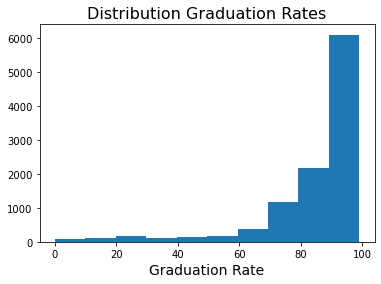

In [55]:
# Plot of the target status group

plt.hist(df_school['grad_rate_midpt'])
plt.xlabel('Graduation Rate', fontsize=14)
plt.title("Distribution Graduation Rates", fontsize=16)
plt.show()


It looks like there is a strong skew towards higher performing high schools. Lets go ahead and bin our values and then take a look at the distribution again.

#### Bin the target

As stated above based on how the federal government defines low graduation rates we will be dividing graduation rates into two bins:
- Low: 66 and below
- High: 67 and above

In [56]:
#Based on the federal government's definition we will define the bin ranges.
grad_rate_bins = [0,66,100]

In [57]:
# now lets convert the grad_rate_midpt column to binned categories
# note that when binning these, the default setting is that the values on the right are included in the bin

df_school['grad_rate_midpt'] = pd.cut(df_school['grad_rate_midpt'], grad_rate_bins)

In [58]:
# and we will also take a look at the distribution across bins 
print(df_school['grad_rate_midpt'].value_counts(normalize=True, dropna=False))

(66.0, 100.0]    0.912287
(0.0, 66.0]      0.087618
NaN              0.000095
Name: grad_rate_midpt, dtype: float64


In [59]:
df_school = df_school.dropna(subset=['grad_rate_midpt'])
df_school.shape

(10579, 58)

In [60]:
print(df_school['grad_rate_midpt'].value_counts(normalize=True, dropna=False))

(66, 100]    0.912374
(0, 66]      0.087626
Name: grad_rate_midpt, dtype: float64


In [61]:
# We will need to address this class imbalance


#### Encode the target

In [62]:
df_school['grad_rate_midpt'].value_counts(normalize=True, dropna=False)

(66, 100]    0.912374
(0, 66]      0.087626
Name: grad_rate_midpt, dtype: float64

In [63]:
 df_school['grad_rate_midpt'] = df_school['grad_rate_midpt'].astype(str)

In [64]:
df_school['grad_rate_midpt'].value_counts(normalize=True, dropna=False)

(66, 100]    0.912374
(0, 66]      0.087626
Name: grad_rate_midpt, dtype: float64

In [65]:
 df_school['grad_rate_midpt'] = df_school['grad_rate_midpt'].replace('(0, 66]', 1)

In [66]:
 df_school['grad_rate_midpt'] = df_school['grad_rate_midpt'].replace('(66, 100]', 0)

### subject enrollment - drop all enrl columns

In [67]:
#Let's look at how many nulls we are dealing with now
percent_null_df(df_school,'df_school')

'percent of nulls in df_school is 4%'

In [68]:
df_school.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10579 entries, 33 to 4905
Data columns (total 58 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ncessch                          10579 non-null  int64  
 1   school_name                      10579 non-null  object 
 2   state_name                       10579 non-null  object 
 3   lea_name                         10579 non-null  object 
 4   urban_centric_locale             10579 non-null  object 
 5   school_level                     10579 non-null  object 
 6   school_type                      10579 non-null  object 
 7   charter                          9970 non-null   object 
 8   enrollment                       10572 non-null  object 
 9   read_test_num_valid              10372 non-null  float64
 10  read_test_pct_prof_low           10214 non-null  object 
 11  read_test_pct_prof_high          10214 non-null  object 
 12  read_test_pct_prof

The class subject enrollment columns stand out as having the most null values let's drop those columns.

In [69]:
df_school = df_school.drop(['enrl_biology', 'enrl_chemistry','enrl_advanced_math',
                            'enrl_calculus','enrl_algebra2','enrl_physics',
                            'enrl_geometry'], axis=1)

In [70]:
#How do our nulls look
percent_null_df(df_school,'df_school')

'percent of nulls in df_school is 2%'

### Encode Charter

In [71]:
df_school['charter'].value_counts(normalize=True, dropna=False)

No     0.858777
Yes    0.083656
NaN    0.057567
Name: charter, dtype: float64

In [72]:
 df_school['charter'] = df_school['charter'].replace('No', 0)

In [73]:
 df_school['charter'] = df_school['charter'].replace('Yes', 1)

In [74]:
df_school['charter'].value_counts(normalize=True, dropna=False)

0.0    0.858777
1.0    0.083656
NaN    0.057567
Name: charter, dtype: float64

We will group the small proportion of NaN values with the majority class which is zero or a non charter school.

In [75]:
df_school.update(df_school[['charter']].fillna(0))

### Reading and Math Tests

In [76]:
df_school.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10579 entries, 33 to 4905
Data columns (total 51 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ncessch                          10579 non-null  int64  
 1   school_name                      10579 non-null  object 
 2   state_name                       10579 non-null  object 
 3   lea_name                         10579 non-null  object 
 4   urban_centric_locale             10579 non-null  object 
 5   school_level                     10579 non-null  object 
 6   school_type                      10579 non-null  object 
 7   charter                          10579 non-null  float64
 8   enrollment                       10572 non-null  object 
 9   read_test_num_valid              10372 non-null  float64
 10  read_test_pct_prof_low           10214 non-null  object 
 11  read_test_pct_prof_high          10214 non-null  object 
 12  read_test_pct_prof

In [77]:
read_test = ['school_name', 'read_test_num_valid', 'read_test_pct_prof_low', 
             'read_test_pct_prof_high', 'read_test_pct_prof_midpt']

In [78]:
df_school[read_test].head(20)

,school_name,read_test_num_valid,read_test_pct_prof_low,read_test_pct_prof_high,read_test_pct_prof_midpt
33,E. O. Smith High School,260.0,82,82,82
36,Common Ground High School,39.0,30,39,34.5
37,The Bridge Academy,139.0,20,24,22
38,Explorations,21.0,21,39,30
40,Stamford Academy,25.0,0,20,10
42,Ansonia High School,137.0,50,54,52
47,Avon High School,244.0,90,90,90
48,Berlin High School,231.0,74,74,74
49,Path Academy,6.0,0,49,24.5
50,Bethel High School,199.0,75,79,77


In [79]:
math_test = ['school_name', 'math_test_num_valid' , 'math_test_pct_prof_low', 
             'math_test_pct_prof_high', 'math_test_pct_prof_midpt']

In [80]:
df_school[math_test].head(20)

,school_name,math_test_num_valid,math_test_pct_prof_low,math_test_pct_prof_high,math_test_pct_prof_midpt
33,E. O. Smith High School,260.0,55,55,55
36,Common Ground High School,39.0,0,10,5
37,The Bridge Academy,139.0,6,9,7.5
38,Explorations,21.0,0,20,10
40,Stamford Academy,25.0,0,20,10
42,Ansonia High School,137.0,20,24,22
47,Avon High School,246.0,77,77,77
48,Berlin High School,231.0,49,49,49
49,Path Academy,6.0,0,49,24.5
50,Bethel High School,199.0,55,59,57


The read_test_num_valid column and the math_test_num_valid column desribe the Number of students who completed a reading, and math assessment and for whom a proficiency level was assigned

The low, high, and midpt columns describe the low, high, and midpoint of the range used to report the share of students scoring proficient on a reading or language arts assessment (0–100 scale)



In [81]:
# The midpoint column is the most balanced measure so we will drop the others
df_school = df_school.drop(['math_test_pct_prof_low','math_test_pct_prof_high',
                           'read_test_pct_prof_low','read_test_pct_prof_high'], axis=1)

### Numeric Columns - nulls

Let's take a look at our columns and check back in on the proportion of nulls. If our proportion is small we will fill the NaNs in the remaining numerical columns with medians.

In [82]:
df_school.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10579 entries, 33 to 4905
Data columns (total 47 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ncessch                          10579 non-null  int64  
 1   school_name                      10579 non-null  object 
 2   state_name                       10579 non-null  object 
 3   lea_name                         10579 non-null  object 
 4   urban_centric_locale             10579 non-null  object 
 5   school_level                     10579 non-null  object 
 6   school_type                      10579 non-null  object 
 7   charter                          10579 non-null  float64
 8   enrollment                       10572 non-null  object 
 9   read_test_num_valid              10372 non-null  float64
 10  read_test_pct_prof_midpt         10214 non-null  object 
 11  math_test_num_valid              10364 non-null  float64
 12  math_test_pct_prof

In [83]:
#How do our nulls look?
percent_null_df(df_school,'df_school')

'percent of nulls in df_school is 2%'

In [84]:
column_names = list(df_school.columns)

In [85]:
categorical = ['year','ncessch','school_name','state_name','lea_name','zip_location',
               'urban_centric_locale','school_level','school_type','charter',
               'corpinstances_preschool']


In [86]:
# We've dropped some of our numerical columns let's update our numerical list
numerical = set(column_names) - set(categorical)
numerical = list(numerical)
numerical

['allegations_harass_disability',
 'allegations_harass_sex',
 'salaries_teachers',
 'instances_phys_restraint',
 'students_report_harass_dis',
 'students_susp_out_sch_multiple',
 'transfers_alt_sch_disc',
 'students_report_harass_race',
 'instances_mech_restraint',
 'students_mech_restraint',
 'days_suspended',
 'cohort_num',
 'allegations_harass_race',
 'math_test_pct_prof_midpt',
 'expulsions_zero_tolerance',
 'students_susp_out_sch_single',
 'students_phys_restraint',
 'suspensions_instances_preschool',
 'students_referred_law_enforce',
 'students_disc_harass_sex',
 'students_disc_harass_race',
 'students_susp_in_sch',
 'grad_rate_midpt',
 'expulsions_no_ed_serv',
 'allegations_harass_religion',
 'enrollment',
 'instances_seclusion',
 'students_disc_harass_dis',
 'math_test_num_valid',
 'students_seclusion',
 'students_SAT_ACT',
 'read_test_num_valid',
 'students_report_harass_sex',
 'read_test_pct_prof_midpt',
 'expulsions_with_ed_serv',
 'corpinstances',
 'suspensions_instances',


In [87]:
numerical.remove('grad_rate_midpt')

In [88]:
nan_values = df_school.isna()
nan_columns = nan_values.any()
columns_with_nan = df_school.columns[nan_columns].tolist()
print(columns_with_nan)

['enrollment', 'read_test_num_valid', 'read_test_pct_prof_midpt', 'math_test_num_valid', 'math_test_pct_prof_midpt', 'students_susp_in_sch', 'students_susp_out_sch_single', 'students_susp_out_sch_multiple', 'expulsions_no_ed_serv', 'expulsions_with_ed_serv', 'expulsions_zero_tolerance', 'students_arrested', 'students_referred_law_enforce', 'transfers_alt_sch_disc', 'days_suspended', 'suspensions_instances_preschool', 'suspensions_instances', 'corpinstances', 'salaries_teachers', 'allegations_harass_sex', 'allegations_harass_race', 'allegations_harass_disability', 'allegations_harass_orientation', 'allegations_harass_religion', 'students_disc_harass_dis', 'students_disc_harass_race', 'students_disc_harass_sex', 'students_report_harass_dis', 'students_report_harass_race', 'students_report_harass_sex', 'instances_mech_restraint', 'instances_phys_restraint', 'instances_seclusion', 'students_mech_restraint', 'students_phys_restraint', 'students_seclusion', 'students_SAT_ACT']


In [89]:
#Replace NaNs with median for each column
df_school[numerical] = df_school[numerical].fillna(df_school[numerical].median())

In [90]:
nan_values = df_school.isna()
nan_columns = nan_values.any()
columns_with_nan = df_school.columns[nan_columns].tolist()
print(columns_with_nan)

[]


In [91]:
df_school[numerical] = df_school[numerical].astype(str).astype(float).astype(int)

In [92]:
#How do our nulls look?
percent_null_df(df_school,'df_school')

'percent of nulls in df_school is 0%'

## df_district

In [93]:
#Concatenate district info for all three states into one dataframe
df_district = pd.concat([df_school_northeast, #df_school_south_atl, 
                         df_school_midwest, df_school_west])

In [94]:
df_district['state_name'].value_counts(normalize=True, dropna=False)

California       0.155548
New York         0.073372
Ohio             0.061990
Minnesota        0.057910
Michigan         0.056621
Illinois         0.053400
Pennsylvania     0.048246
Arizona          0.046958
Washington       0.040444
Missouri         0.040086
Wisconsin        0.036006
New Jersey       0.033644
Indiana          0.027058
Massachusetts    0.024481
Colorado         0.024481
Connecticut      0.023336
Iowa             0.022691
Kansas           0.022047
Nebraska         0.019900
Oregon           0.017895
New Mexico       0.013815
Idaho            0.013099
South Dakota     0.013028
Utah             0.012742
Montana          0.012241
North Dakota     0.011954
Nevada           0.008089
Maine            0.007874
New Hampshire    0.006729
Wyoming          0.006013
Vermont          0.004295
Rhode Island     0.004009
Name: state_name, dtype: float64

### Data Fields

In [95]:
df_district.head()

,year,ncessch,school_name,state_name,lea_name,zip_location,urban_centric_locale,school_level,school_type,charter,...,enrl_algebra2,enrl_physics,enrl_geometry,instances_mech_restraint,instances_phys_restraint,instances_seclusion,students_mech_restraint,students_phys_restraint,students_seclusion,students_SAT_ACT
0,2015,90000201136,A. I. Prince Technical High School,Connecticut,Connecticut Technical High Sc,6106,"City, midsize",High,Vocational school,No,...,212.0,66.0,180.0,0.0,0.0,0.0,0.0,0.0,0.0,243.0
1,2015,90000201137,Bullard-Havens Technical High School,Connecticut,Connecticut Technical High Sc,6610,"City, midsize",High,Vocational school,No,...,180.0,NaN,207.0,0.0,0.0,0.0,0.0,0.0,0.0,320.0
2,2015,90000201138,E. C. Goodwin Technical High School,Connecticut,Connecticut Technical High Sc,6053,"Suburb, large",High,Vocational school,No,...,308.0,45.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,209.0
3,2015,90000201139,Ella T. Grasso Southeastern Technical High School,Connecticut,Connecticut Technical High Sc,6340,"Rural, fringe",High,Vocational school,No,...,165.0,35.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,156.0
4,2015,90000201140,Eli Whitney Technical High School,Connecticut,Connecticut Technical High Sc,6514,"Suburb, large",High,Vocational school,No,...,150.0,NaN,147.0,0.0,0.0,0.0,0.0,0.0,0.0,171.0


In [96]:
df_district.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13970 entries, 0 to 4907
Data columns (total 64 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   year                             13970 non-null  int64  
 1   ncessch                          13970 non-null  int64  
 2   school_name                      13970 non-null  object 
 3   state_name                       13970 non-null  object 
 4   lea_name                         13970 non-null  object 
 5   zip_location                     13970 non-null  object 
 6   urban_centric_locale             13945 non-null  object 
 7   school_level                     13970 non-null  object 
 8   school_type                      13970 non-null  object 
 9   charter                          13970 non-null  object 
 10  enrollment                       13970 non-null  object 
 11  read_test_num_valid              12263 non-null  float64
 12  read_test_pct_prof_

In [97]:
#What proportion of our data frame is nulls?
percent_null_df(df_district,'df_district')

'percent of nulls in df_district is 10%'

Not bad. Let's deal with that 4%

#### Data Field Cleanup

In [98]:
column_names = list(df_district.columns)

In [99]:
categorical = ['year','leaid','leaname','state_name','state_leaid','city_location',
               'urban_centric_locale','agency_type']


In [100]:
for ele in categorical:
    try:
        column_names.remove(ele)
    except ValueError:
        pass

In [101]:
numerical = column_names

In [102]:
column_names = list(df_district.columns)

In [103]:
for c in column_names:
    df_district[c].replace('Suppressed data', np.NaN,inplace =True)

In [104]:
for c in column_names:
    df_district[c].replace('Not applicable', np.NaN,inplace =True)

In [105]:
for c in column_names:
    df_district[c].replace('Missing/not reported', np.NaN,inplace =True)

### Columns to drop

In [106]:
df_district.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13970 entries, 0 to 4907
Data columns (total 64 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   year                             13970 non-null  int64  
 1   ncessch                          13970 non-null  int64  
 2   school_name                      13970 non-null  object 
 3   state_name                       13970 non-null  object 
 4   lea_name                         13970 non-null  object 
 5   zip_location                     13212 non-null  object 
 6   urban_centric_locale             13945 non-null  object 
 7   school_level                     13970 non-null  object 
 8   school_type                      13970 non-null  object 
 9   charter                          13294 non-null  object 
 10  enrollment                       13700 non-null  object 
 11  read_test_num_valid              12263 non-null  float64
 12  read_test_pct_prof_

In [107]:
df_district = df_district.drop([], axis=1)

In [108]:
# Our population columns have the highest proportion of nulls
df_district = df_district.drop(['est_population_total','est_population_5_17_poverty',
                           'est_population_5_17_poverty_pct'], axis=1)

KeyError: "['est_population_total' 'est_population_5_17_poverty'\n 'est_population_5_17_poverty_pct'] not found in axis"

In [ ]:
# Drop grad rates: we don't want to delete any districts and are using grad rate at school level
df_district = df_district.drop(['grad_rate_high','grad_rate_low',
                                'grad_rate_midpt','cohort_num'], axis=1)

In [ ]:
df_district['enrollment'].value_counts(normalize=True, dropna=False)

In [ ]:
# Enrollment is mostly zeros or NaNs 
df_district = df_district.drop(['enrollment'], axis=1)

In [ ]:
# year is the same for all rows, state_name same in school data, state_leaid unnecessary
df_district = df_district.drop(['year','state_name','state_leaid'], axis=1)

In [ ]:
#What proportion of our data frame is nulls?
percent_null_df(df_district,'df_district')

### english_language_learners

In [ ]:
df_district['english_language_learners'].value_counts(normalize=True, dropna=False)

In [ ]:
ell = ['english_language_learners']

In [ ]:
for c in ell:
    df_district[c].replace('Missing/not reported', np.NaN,inplace =True)

In [ ]:
df_district['english_language_learners'].value_counts(normalize=True, dropna=False)

In [ ]:
# fill na with median
df_district['english_language_learners'] = df_district['english_language_learners'].fillna(df_district['english_language_learners'].median())

In [ ]:
df_district['english_language_learners'].value_counts(normalize=True, dropna=False)

In [ ]:
df_district.info()

In [ ]:
df_district = df_district.drop_duplicates(subset=['lea_name'])

# Join Datasets

In [ ]:
df_school.shape

In [ ]:
df_district.shape

In [ ]:
# Columns to drop 
df_school = df_school.drop(['ncessch','school_level','school_type','school_name','suspensions_instances_preschool'], axis=1)

In [ ]:
df_train = df_school.merge(df_district, on = 'lea_name')
df_train.head()

In [ ]:
df_train.info()

In [ ]:
# Columns to drop - we don't need these anymore 
df_train = df_train.drop(['leaid','lea_name'], axis=1)

## Final Check for NaNs

In [ ]:
nan_values = df_train.isna()
nan_columns = nan_values.any()

In [ ]:
columns_with_nan = df_train.columns[nan_columns].tolist()
print(columns_with_nan)

We still have NaN values in our numerical fields

# Numeric Columns - cleanup

In [ ]:
col_names_category = ['state_name','urban_centric_locale_x','city_location',
                      'urban_centric_locale_y','agency_type','grad_rate_midpt']

In [ ]:
col_names = list(df_train.columns)

In [ ]:
num_col_names = set(col_names) - set(col_names_category)
num_col_names = list(num_col_names)

In [ ]:
df_train[num_col_names] = df_train[num_col_names].fillna(df_train[num_col_names].median())

In [ ]:
df_train[num_col_names] = df_train[num_col_names].astype(str).astype(float).astype(int)

# Category Columns - cleanup

In [ ]:
df_train[col_names_category] = df_train[col_names_category].astype('category')

In [ ]:
col_names_ohe = ['state_name','urban_centric_locale_x','city_location',
                 'urban_centric_locale_y','agency_type']

In [ ]:
df_train[col_names_ohe] = df_train[col_names_ohe].astype(str)

In [ ]:
df_train.info()

# Train Test Split

In [ ]:
X=df_train.drop(columns = ['grad_rate_midpt']) # Features
y=df_train['grad_rate_midpt'] #Target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

In [ ]:
X_train

In [ ]:
X_train.shape

In [ ]:
X_test.shape

# Encode Features

In [ ]:
X_train_ohe = X_train[col_names_ohe]
X_test_ohe = X_test[col_names_ohe]

## X_train Encode

In [ ]:
X_train.info()

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore',sparse=False)

In [ ]:
X_train_ohe.info()

In [ ]:
enc.fit(X_train_ohe) 

In [ ]:
enc.categories_

In [ ]:
X_train2 = enc.transform(X_train_ohe)

In [ ]:
X_train2.shape

In [ ]:
enc.get_feature_names()
column_name = enc.get_feature_names()
one_hot_encoded_frame =  pd.DataFrame(X_train2, columns= column_name)

In [ ]:
X_train = one_hot_encoded_frame.reset_index(drop=True).merge(X_train.reset_index(drop=True), left_index=True, right_index=True)


In [ ]:
X_train.drop(col_names_ohe, axis=1, inplace=True)
X_train




## X_test Encode

In [ ]:
X_test.info()

In [ ]:
enc.categories_

In [ ]:
X_test2 = enc.transform(X_test_ohe)

In [ ]:
X_test2.shape

In [ ]:
enc.get_feature_names()
column_name = enc.get_feature_names()
one_hot_encoded_frame =  pd.DataFrame(X_test2, columns= column_name)

In [ ]:
X_test = one_hot_encoded_frame.reset_index(drop=True).merge(X_test.reset_index(drop=True), left_index=True, right_index=True)


In [ ]:
X_test.drop(col_names_ohe, axis=1, inplace=True)
X_test

In [ ]:
X_train.shape

In [ ]:
X_test.shape

# Model Development

## Logistic Regression

In [ ]:
# Logistic model
log_clf = LogisticRegression(class_weight='balanced')
log_model = log_clf.fit(X_train, y_train)
y_pred_train = log_model.predict(X_train)
y_pred = log_model.predict(X_test)

In [ ]:
#Confusion matrix for Logistic Regression
log_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', log_matrix)

In [ ]:
print('The f1 score for the training model is:',f1_score(y_train, y_pred_train))
print('The f1 score for the model is:',f1_score(y_test, y_pred))

In [ ]:
print(metrics.classification_report(y_test, y_pred, labels=[0,1],
                                    target_names=['normal grad. rate','low grad rate']))

### Check for Overfit

In [ ]:
# View confusion matrix for train data and predictions
confusion_matrix(y_train, y_pred_train)

In [ ]:
# View confusion matrix for test data and predictions
confusion_matrix(y_test, y_pred)

In [ ]:
print(metrics.classification_report(y_train, y_pred_train, labels=[0,1],
                                    target_names=['normal grad. rate','low grad rate']))

In [ ]:
print(metrics.classification_report(y_test, y_pred, labels=[0,1],
                                    target_names=['normal grad. rate','low grad rate']))

### Model reiteration - parameter tuning

In [ ]:
# Logistic model
log_clf = LogisticRegression( class_weight='balanced')
log_model = log_clf.fit(X_train, y_train)
y_pred_train = log_model.predict(X_train)
y_pred = log_model.predict(X_test)

In [ ]:
model_params = {
    #Algorithm to use in the optimization problem
    'solver': ['newton-cg', 'sag', 'saga','lbfgs'],
    # Maximum number of iterations taken for the solvers to converge
    'max_iter': [10,50,100],
    # random state
    'random_state': [1]
}

In [ ]:
# Instantiate and fit the LogisticReg Model
log_clf = LogisticRegression(class_weight='balanced')
log_clf = GridSearchCV(log_clf,model_params,scoring = 'recall')
log_clf.fit(X_train,y_train)

In [ ]:
LogisticRegression(class_weight='balanced').get_params().keys()

In [ ]:
print(log_clf.best_estimator_.get_params())

In [ ]:
print('The f1 score for the training model is:',f1_score(y_train, y_pred_train))
print('The f1 score for the model is:',f1_score(y_test, y_pred))

In [ ]:
print(metrics.classification_report(y_train, y_pred_train, labels=[0,1],
                                    target_names=['normal grad. rate','low grad rate']))

In [ ]:
print(metrics.classification_report(y_test, y_pred, labels=[0,1],
                                    target_names=['normal grad. rate','low grad rate']))

## Random Forest Classifier

In [ ]:
# Instantiate and fit the RandomForestClassifier
rfc=RandomForestClassifier(n_estimators=10,class_weight='balanced')
rfc.fit(X_train,y_train)

In [ ]:
training_start = time.perf_counter()
rfc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
y_pred = rfc.predict(X_test)
y_pred_train = rfc.predict(X_train)
prediction_end = time.perf_counter()
acc_rfc = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Time consumed for training: %4.3f seconds" % (rfc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (rfc_prediction_time))

In [ ]:
print('The f1 score for the training model is:',f1_score(y_train, y_pred_train))
print('The f1 score for the model is:',f1_score(y_test, y_pred))

In [ ]:
print(metrics.classification_report(y_test, y_pred, labels=[0,1],
                                    target_names=['normal grad rate','low grad rate']))

### Check for Overfit

In [ ]:
# View confusion matrix for train data and predictions
confusion_matrix(y_train, y_pred_train)

In [ ]:
# View confusion matrix for test data and predictions
confusion_matrix(y_test, y_pred)

In [ ]:
rfc_training_preds = rfc.predict(X_train)
rfc_training_f1 = f1_score(y_train, rfc_training_preds)

rfc_val_preds = rfc.predict(X_test) # y_hat
rfc_val_f1 = f1_score(y_test, rfc_val_preds)
print(rfc_training_f1)
print(rfc_val_f1)

In [ ]:
print(metrics.classification_report(y_train, y_pred_train, labels=[0,1], 
                                    target_names=['normal grad rate','low grad rate']))

In [ ]:
print(metrics.classification_report(y_test, y_pred, labels=[0,1]))

### Feature Importance

In [ ]:
# create list so that random forest model important features are named
rfc_columns = list(X_train.columns)

In [ ]:
feat_importances = pd.Series(rfc.feature_importances_, index = rfc_columns)
feat_importances.nlargest(20).plot(kind='barh')

### Model reiteration - parameter tuning

In [ ]:
model_params = {
    # number of 
    'n_estimators': [5,10,20,50,100,200],
    # number of max features
    'max_features': [10,15,20,50,100],
    # max number of levels in each decision tree
    'max_depth': [5,10,15],
    # minimum amount of samples in a node
    'min_samples_leaf': [10],
    # minimum amount of samples to split
    'min_samples_split' : [100,1000],
    # random state
    'random_state': [1]
    
}

In [ ]:
# Instantiate and fit the RandomForestClassifier
rfc=RandomForestClassifier(class_weight='balanced')
rfc = GridSearchCV(rfc, model_params, scoring = 'recall')
rfc.fit(X_train,y_train)

In [ ]:
print(rfc.best_estimator_.get_params())

In [ ]:
print('The f1 score for the training model is:',f1_score(y_train, y_pred_train))
print('The f1 score for the model is:',f1_score(y_test, y_pred))

In [ ]:
print(metrics.classification_report(y_train, y_pred_train, labels=[0,1],
                                    target_names=['normal grad. rate','low grad rate']))

In [ ]:
print(metrics.classification_report(y_test, y_pred, labels=[0,1],
                                    target_names=['normal grad. rate','low grad rate']))

## Gradient Boosting Classifier

In [ ]:
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)
y_pred = gb_clf.predict(X_test)
y_pred_train = gb_clf.predict(X_train)

# print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
# print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))

In [ ]:
print('The f1 score for the training model is:',f1_score(y_train, y_pred_train))
print('The f1 score for the model is:',f1_score(y_test, y_pred))

In [ ]:
print(metrics.classification_report(y_test, y_pred, labels=[0,1],
                                    target_names=['normal grad. rate','low grad rate']))

### Check for Overfit

In [ ]:
# View confusion matrix for train data and predictions
confusion_matrix(y_train, y_pred_train)

In [ ]:
# View confusion matrix for test data and predictions
confusion_matrix(y_test, y_pred)

In [ ]:
print(metrics.classification_report(y_train, y_pred_train, labels=[0,1],
                                    target_names=['normal grad. rate','low grad rate']))

In [ ]:
print(metrics.classification_report(y_test, y_pred, labels=[0,1],
                                    target_names=['normal grad. rate','low grad rate']))

### Model reiteration - parameter tuning

In [ ]:
model_params = {
    # number of boosting stages
    'n_estimators': [5,10,20,50,100,200],
    # number of max features
    'max_features': [10,15,20,50,100],
     # minimum amount of samples in a node
    'min_samples_leaf': [10],
    # Learning rate
    'learning_rate':[.25,.5,.75,1],
    #The minimum number of samples required to split an internal node
    'min_samples_split' : [100,1000],
     # random state
    'random_state':[1]
}

In [ ]:
gb_clf = GradientBoostingClassifier()
gb_clf = GridSearchCV(gb_clf,model_params, scoring = 'recall')
gb_clf.fit(X_train,y_train)

In [ ]:
print(metrics.classification_report(y_train, y_pred_train, labels=[0,1],
                                    target_names=['normal grad. rate','low grad rate']))

In [ ]:
print(metrics.classification_report(y_test, y_pred, labels=[0,1],
                                    target_names=['normal grad. rate','low grad rate']))

In [ ]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate)
    gb_clf.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))
    print('The f1 score for the training model is:',f1_score(y_train, y_pred_train))
    print('The f1 score for the model is:',f1_score(y_test, y_pred))

# Conclusions

# Recommendations

# Future Work

# Might Use Later

In [ ]:
column_names = list(df_school.columns)

In [ ]:
categorical = ['year','ncessch','school_name','state_name','lea_name','zip_location',
               'urban_centric_locale','school_level','school_type','charter',
               'corpinstances_preschool']


In [ ]:
#use for loop if statement to create numerical list is more intuitive
for ele in categorical:
    try:
        column_names.remove(ele)
    except ValueError:
        pass

In [ ]:
numerical = column_names

In [ ]:
# # Set it equal to regular instead of taking out each of the three
# df_school.drop(df_school[df_school['school_type'] == 'Other/alternative school' ].index, inplace = True)
# df_school.shape[0]

In [ ]:
# df_school.drop(df_school[df_school['school_type'] == 'Vocational school' ].index, inplace = True)
# df_school.shape[0]

In [ ]:
# df_school.drop(df_school[df_school['school_type'] == 'Special education school' ].index, inplace = True)
# df_school.shape[0]

Change Sci kit learn OHE set sparse to false set handle errors to ignore drop first equals if binary

Change Sci kit learn OHE set sparse to false set handle errors to ignore drop first equals if binary

In [ ]:
# print top 5 most frequent values in each grad_rate column
for col in df_school['grad_rate_midpt'].columns:
    print(col, '\n', df_school[col].value_counts(normalize=True).head(), '\n\n')


In [ ]:
def target_col (row):
   if row['eri_hispanic   '] == 1 :
      return 'Hispanic'
   if row['eri_afr_amer'] + row['eri_asian'] + row['eri_hawaiian'] + row['eri_nat_amer'] + row['eri_white'] > 1 :
      return 'Two Or More'
   if row['eri_nat_amer'] == 1 :
      return 'A/I AK Native'
   if row['eri_asian'] == 1:
      return 'Asian'
   if row['eri_afr_amer']  == 1:
      return 'Black/AA'
   if row['eri_hawaiian'] == 1:
      return 'Haw/Pac Isl.'
   if row['eri_white'] == 1:
      return 'White'
   return 'Other'


In [ ]:
# Returns the percentage of values in a dataframe that are nulls
def null_cleanup_numeric(col_null):
    return
    # Declare Median
    median = col_null.median()
    # fillna with zeros 
    col_null.update(col_null.fillna(0))
    # convert columns to numeric
    col_null.astype(str).astype(float)
    # Replace zeros with median
    col_null.replace([0], median)
    
   

In [ ]:
df_school[['read_test_num_valid','math_test_num_valid']] = df_school[['read_test_num_valid','math_test_num_valid']].apply(null_cleanup_numeric)

In [ ]:
df_school.info()

In [ ]:
# fillna with zeros so we can convert to numeric
df_school.update(df_school[['math_test_pct_prof_midpt']].fillna(0))
df_school.update(df_school[['read_test_pct_prof_midpt']].fillna(0))

In [ ]:
# convert grad rate columns to numeric
df_school[['math_test_pct_prof_midpt']] = df_school[['math_test_pct_prof_midpt']].astype(str).astype(float)
df_school[['read_test_pct_prof_midpt']] = df_school[['read_test_pct_prof_midpt']].astype(str).astype(float)


In [ ]:
# Replace the two null values with the median of the midpoint columns
math_median = df_school['math_test_pct_prof_midpt'].median()
print(math_median)
read_median = df_school['read_test_pct_prof_midpt'].median()
print(read_median)

In [ ]:
# Replace the two null values with the median of the midpoint columns
df_school.update(df_school[['math_test_pct_prof_midpt']].fillna(math_median))
df_school.update(df_school[['read_test_pct_prof_midpt']].fillna(read_median))

In [ ]:
# Replace zeros with median
df_school['math_test_pct_prof_midpt'] = df_school['math_test_pct_prof_midpt'].replace([0], math_median)
df_school['read_test_pct_prof_midpt'] = df_school['read_test_pct_prof_midpt'].replace([0], read_median)

In [ ]:
# Let's take a look at the summary statistics

print(df_school['math_test_pct_prof_midpt'].describe())
print(df_school['read_test_pct_prof_midpt'].describe())

In [ ]:
df_school.info()

In [ ]:
# Returns the percentage of values in a dataframe that are NaNs
def percent_NaN_df (df,str_name):
    count_NaN = df.isna().sum().sum()
    count_non_NaN = df.count().sum()
    return 'percent of NaNs in '+ str_name +' is '+str(int((count_NaN/(count_NaN + count_non_NaN))*100))+'%'
    

In [ ]:
# Our population columns have the highest proportion of nulls let's take at look
population_cols = ['lea_name','state_name','est_population_total','est_population_5_17_poverty',
                           'est_population_5_17_poverty_pct']

In [ ]:
# Our population columns have the highest proportion of nulls let's take at look
population_cols = ['lea_name','state_name','est_population_total','est_population_5_17_poverty',
                           'est_population_5_17_poverty_pct']